# LSTM Notebook
##### Perform Regression on Dividend Data using an LSTM based network
##### Aim to predict next value in sequence

In [1]:
# Importing the libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, InputLayer
from keras.optimizers import SGD
from keras.utils import plot_model
import math
from sklearn.metrics import mean_squared_error

%matplotlib inline

Using TensorFlow backend.


In [2]:
# Load Ticker data from GetTickers.ipynb
kept_status = np.load("data/numpy/kept_status.npy")
lost_status = np.load("data/numpy/lost_status.npy")
lost_status_date = np.load("data/numpy/lost_status_date.npy",allow_pickle=True)

In [3]:
# MSE Function
def MSE(test,predicted):
    mse = mean_squared_error(test, predicted)
    print("The mean squared error is {}.".format(mse))
    
# Split Dataframe into train and test set
def split(dataframe, border, col):
    return dataframe.loc[:border,col], dataframe.loc[border:,col]

In [4]:
# Collect list of all companies we have data for

# Get list of file names
fileList = os.listdir("data/series/good")

# Loop through file names and collect ticker symbols
companyList = []
for file in fileList:
    companyName = file.split("_")[0]
    if companyName not in [".DS",".ipynb"]:
        companyList.append(companyName)
print(companyList)

['VFC', 'KMB', 'NC', 'GWW', 'SJW', 'SEIC', 'EGN', 'NDSN', 'RLI', 'MATW', 'MCD', 'CLX', 'PG', 'UMBF', 'MMM', 'ROST', 'AFL', 'ABT', 'T', 'EXPD', 'CHD', 'BDX', 'GRC', 'FFMR', 'CTAS', 'PII', 'JNJ', 'CBU', 'BKH', 'LANC', 'NUE', 'WTRG', 'WABC', 'BANF', 'ECL', 'CPKF', 'SKT', 'MGEE', 'BEN', 'TGT', 'NEE', 'FLIC', 'CWT', 'TRI', 'CSL', 'NNN', 'ABM', 'CFR', 'SON', 'SRCE', 'CSVI', 'CINF', 'SPGI', 'AWR', 'O', 'IBM', 'WEYS', 'MSA', 'ESS', 'CBSH', 'NJR', 'LOW', 'CVX', 'EFSI', 'PBI', 'TR', 'ALB', 'EMR', 'AROW', 'TMP', 'MCY', 'LEG', 'ED', 'KO', 'NIDB', 'DOV', 'PH', 'ORI', 'FUL', 'TDS', 'WRE', 'MKC', 'FRT', 'PSBQ', 'GPC', 'MO', 'BMS', 'TNC', 'ENB', 'ITW', 'CTBI', 'BRO', 'AOS', 'PEP', 'ATR', 'UBSI', 'NFG', 'SHW', 'MDU', 'SCL', 'ROP', 'UGI', 'ARTNA', 'MGRC', 'WGL', 'MDT', 'CNI', 'LECO', 'TROW', 'RPM', 'ERIE', 'HRL', 'SWK', 'CB', 'ADM', 'APD', 'LIN', 'BMI', 'UHT', 'FMCB', 'ADP', 'CAT', 'SBSI', 'PNR', 'RTX', 'EBTC', 'NWN', 'OZK', 'JKHY', 'PPG', 'DBD', 'ATO', 'GD', 'WST', 'CL', 'WBA', 'TYCB', 'SYY', 'WMT', 'B

In [5]:
# Add to ignore list if no data is available
# Yahoo Finance will occasionally not through error
# for some companies during GetMetrics, which end up creating blank
# csvs that we can simply ignore here
ignoreList = ["FFMR","FMCB"]
stockList = list(set(companyList).difference(ignoreList))

# Load and store data in initial Dataframe
df_ = {}
for i in stockList:
    df_[i] = pd.read_csv("data/series/good/" + i + "_dividends_fixed.csv", index_col="Date", parse_dates=["Date"])

# Create new Dataframe that contains data for each company
# split at specified year
df_new = {}
for i in stockList:
    df_new[i] = {}
    df_new[i]["Train"], df_new[i]["Test"] = split(df_[i], "2006", "0")

In [6]:
# Scale the data
transform_train = {}
transform_test = {}
scaler = {}

for num, i in enumerate(stockList):
    sc = MinMaxScaler(feature_range = (0,1)) # normalize values to be within [0,1]
    train = df_new[i]["Train"].values
    test = df_new[i]["Test"].values
    
    train = np.expand_dims(train, axis = 1)
    test = np.expand_dims(test, axis = 1)
    transform_train[i] = sc.fit_transform(train)
    transform_test[i] = sc.fit_transform(test)
    # Save scalers for predictions at later step
    scaler[i] = sc

# Free up memory
del train
del test

In [7]:
# Dynamically determine which samples have enough information to be trained
# Need every dataset to have a similar length for training/testing

train_lengths = [data.shape[0] for data in transform_train.values()] 
val, ct = np.unique(np.array(train_lengths), return_counts=True)
train_count = val[np.argsort(ct)][-1]

test_lengths = [data.shape[0] for data in transform_test.values()] 
val, ct = np.unique(np.array(test_lengths), return_counts=True)
test_count = val[np.argsort(ct)][-1]

In [8]:
# train_count -= 20
# test_count -= 20
train_count, test_count

(80, 60)

In [9]:
# Determine how many samples will used for prediction
# this will use the previous 5 samples
overlap = 5

trainset = {}
testset = {}

stockListFix = [] # This will contain stocks that have enough samples to be included in training
testDates = {} # collect dates of test samples for later visualizations

# Created data structure for input sets and expected outputs
# Created by sliding window of len overlap across datasets
for j in stockList:
        if transform_train[j].shape[0] < train_count or transform_test[j].shape[0] < test_count:
            continue
        stockListFix.append(j)
        trainset[j] = {}
        X_train = []
        y_train = []
        
        for i in range(overlap,train_count):
            X_train.append(transform_train[j][i-overlap:i,0])
            y_train.append(transform_train[j][i,0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        trainset[j]["X"] = np.expand_dims(X_train, axis=len(X_train.shape))
        trainset[j]["y"] = y_train

        testset[j] = {}
        X_test = []
        y_test = []   
        testDates[j] = []
        for i in range(overlap, test_count):
            X_test.append(transform_test[j][i-overlap:i,0])
            y_test.append(transform_test[j][i,0])
            testDates[j].append(df_new[j]['Test'].index[i])
        X_test, y_test = np.array(X_test), np.array(y_test)
        testset[j]["X"] = np.expand_dims(X_test, axis=len(X_test.shape))
        testset[j]["y"] = y_test

In [10]:
# Visualize dataset shapes for each company
arr_buff = []
for i in stockListFix:
    buff = {}
    buff["X_train"] = trainset[i]["X"].shape
    buff["y_train"] = trainset[i]["y"].shape
    buff["X_test"] = testset[i]["X"].shape
    buff["y_test"] = testset[i]["y"].shape
    arr_buff.append(buff)

pd.DataFrame(arr_buff, index=stockListFix)

,X_train,y_train,X_test,y_test
SHW,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
SCL,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
O,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
MDT,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
APD,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
...,...,...,...,...
MSEX,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
PG,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
TR,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"
GWW,"(75, 5, 1)","(75,)","(55, 5, 1)","(55,)"


/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


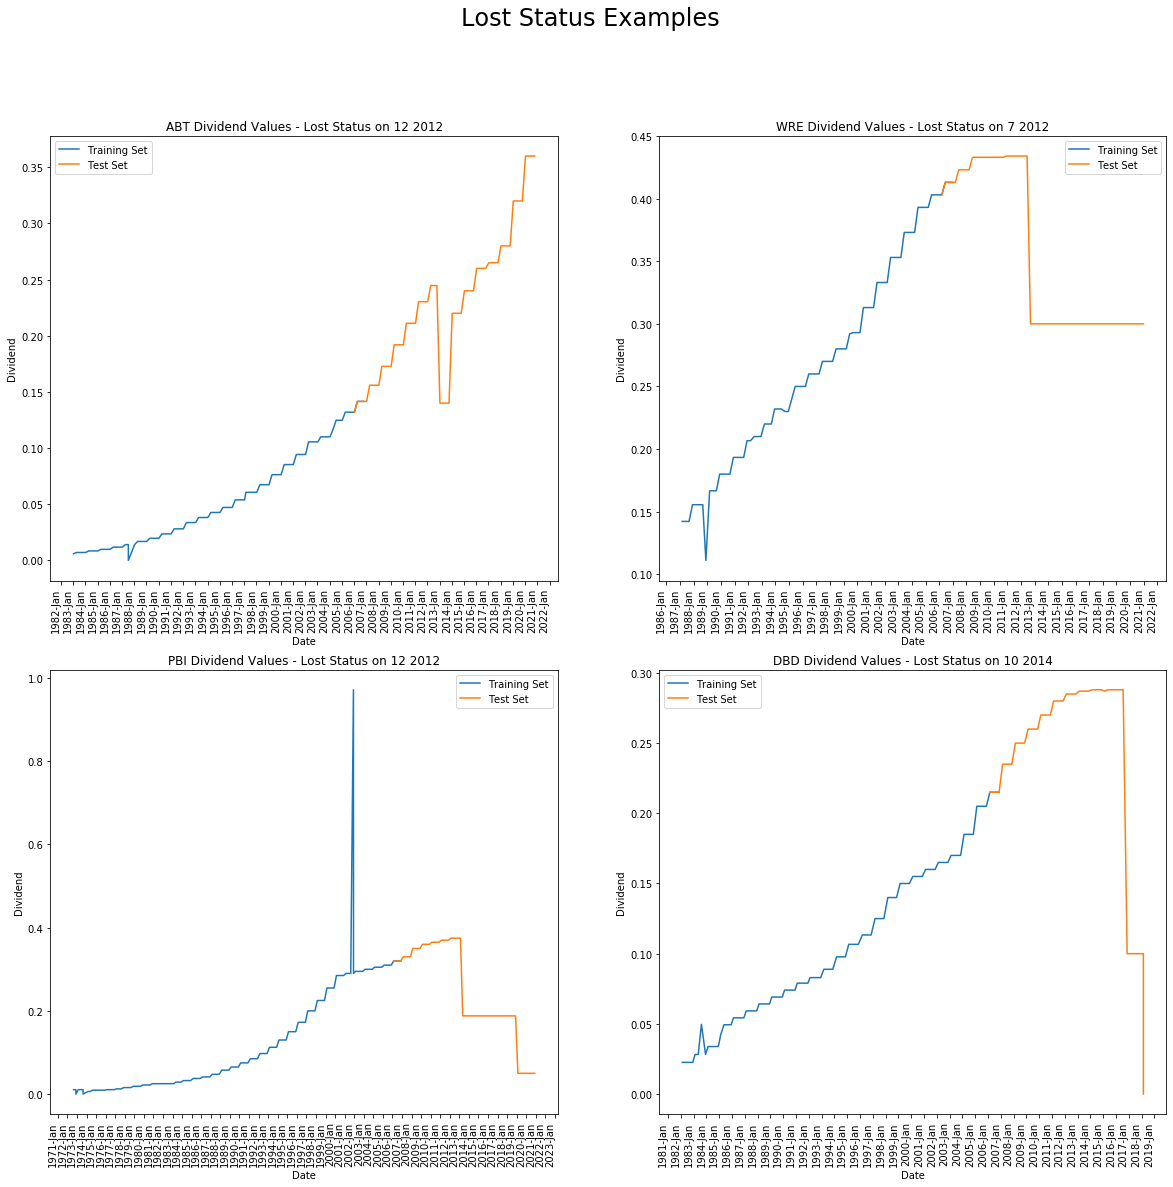

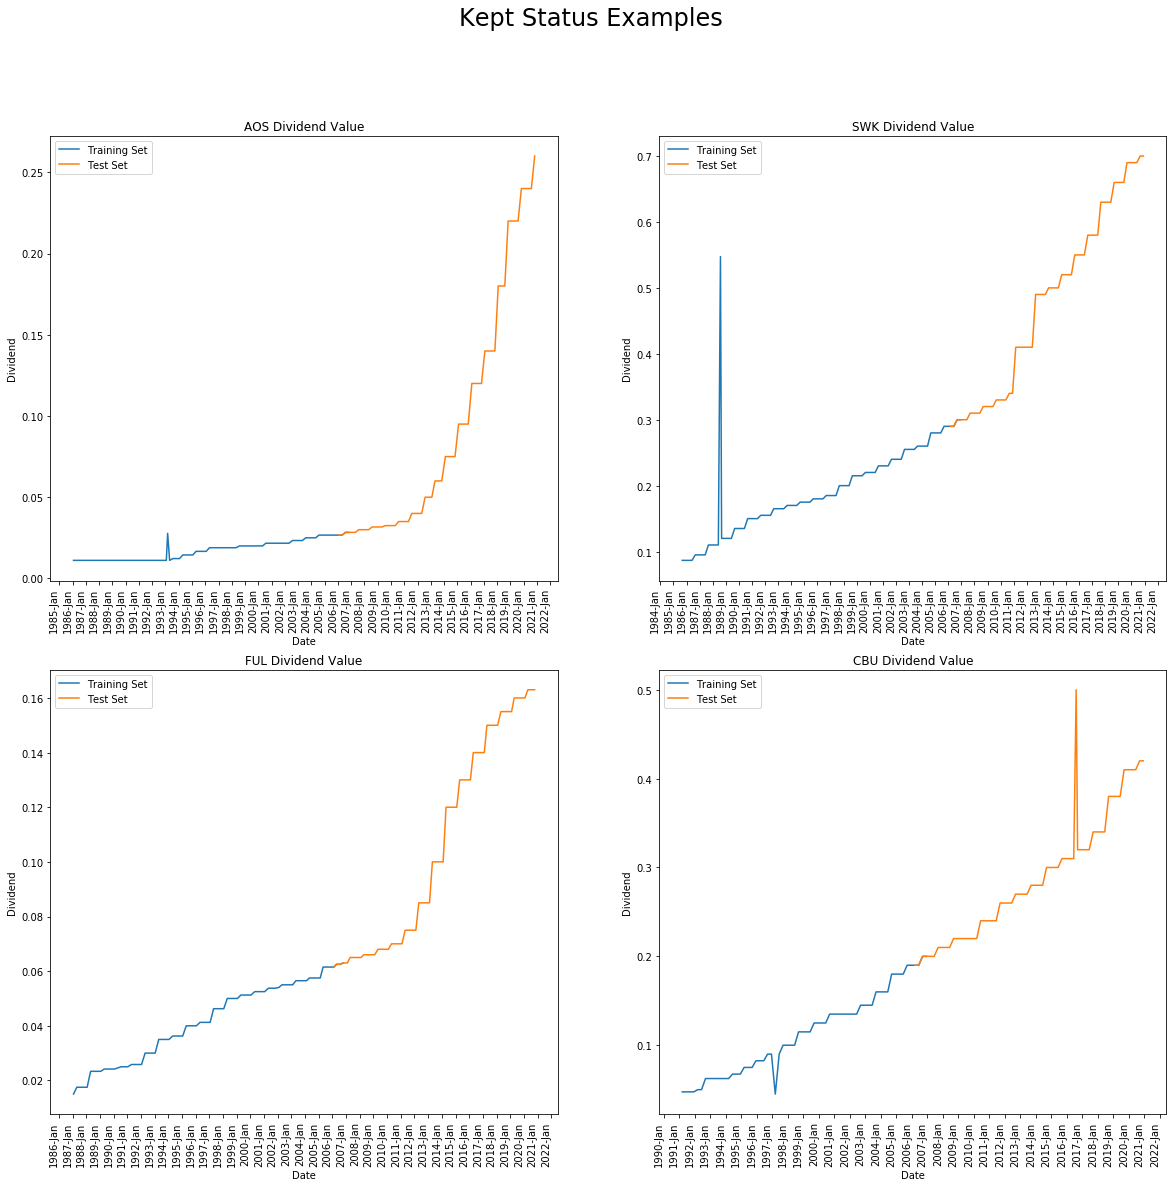

In [11]:
# Plot Examples From Dataset

randidx = np.random.permutation(len(stockList))
shufStockList = np.array(stockList)[randidx]

lost_ct = 0
kept_ct = 0

lost_figs = ["PBI","ABT","WRE","DBD"]
kept_figs = ["CBU","SWK","FUL","AOS"]

lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))
lost_fig.suptitle("Lost Status Examples", fontsize=24)

kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples", fontsize=24)

for i in shufStockList:
    if df_new[i]["Train"].empty or df_new[i]["Test"].empty:
        print(f"No Data For {i}, add to ignoreList and rerun cells")
    if i in lost_figs and lost_ct <= 3:
        indx = lost_ct
        axs = lost_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#         axs.xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_new[i]["Train"].index, df_new[i]["Train"].values)
        axs[indx].plot(df_new[i]["Test"].index,df_new[i]["Test"].values)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Training Set", "Test Set"])  
        dateIdx = [i in lost_status_date[:,2][j] for j in range(len(lost_status_date))]
        date = lost_status_date[dateIdx][0][:2]        
        axs[indx].set_title(i + f" Dividend Values - Lost Status on {date[1]} {date[0]}")   
        # plt.savefig("WRE_Dataset.png", format="png")
        lost_ct += 1
        
    if i in kept_figs and kept_ct <= 3:
        indx = kept_ct
        axs = kept_axs.flat
        axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
#         axs.xaxis.set_minor_locator(mdates.MonthLocator())
        axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
        axs[indx].plot(df_new[i]["Train"].index, df_new[i]["Train"].values)
        axs[indx].plot(df_new[i]["Test"].index,df_new[i]["Test"].values)
        axs[indx].set_ylabel("Dividend")
        axs[indx].set_xlabel("Date")
        for label in axs[indx].get_xticklabels(which='major'):
            label.set(rotation=90, horizontalalignment='right')
        axs[indx].legend(["Training Set", "Test Set"])
        axs[indx].set_title(i + " Dividend Value") 
        # plt.savefig("WRE_Dataset.png", format="png")
        kept_ct += 1

plt.show()

#### NOTE: Some companies in the "lost status" category could have lost status without their being a significant dip in their historical dividend values. For this project, we are focusing on attempting to predict the next dividend value even if it has a sudden decline.

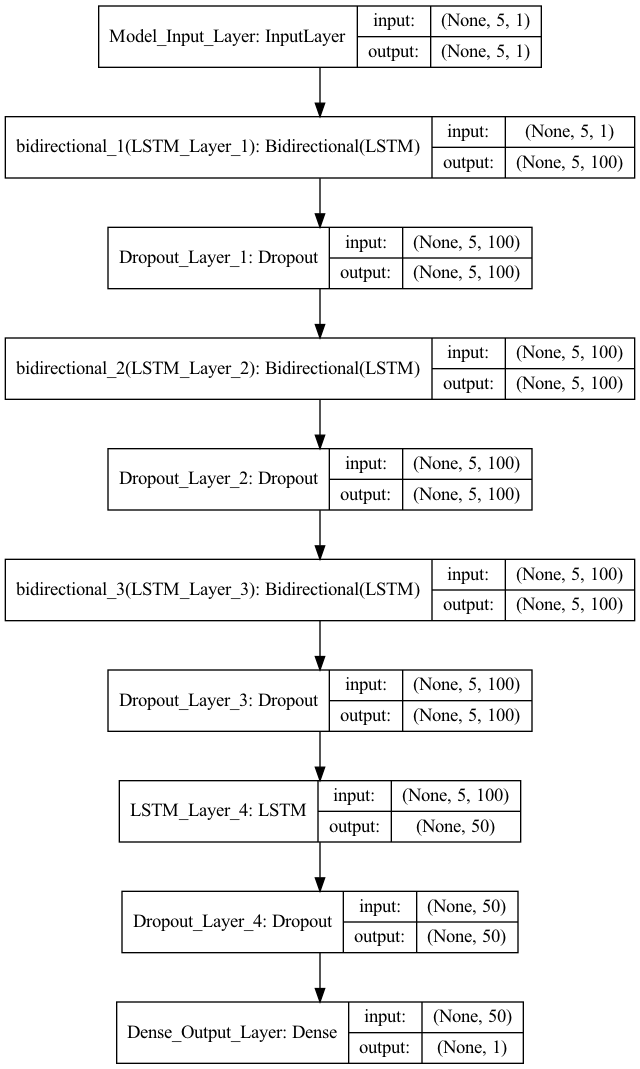

In [12]:
# Create LSTM Model

# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularization
regressor.add(InputLayer(input_shape=(X_train.shape[1],1), name = "Model_Input_Layer"))
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True, name="LSTM_Layer_1")))
regressor.add(Dropout(0.2,name="Dropout_Layer_1"))
# Second LSTM layer
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True,name="LSTM_Layer_2")))
regressor.add(Dropout(0.3,name="Dropout_Layer_2"))
# Third LSTM layer
regressor.add(Bidirectional(LSTM(units=50, return_sequences=True,name="LSTM_Layer_3")))
regressor.add(Dropout(0.3,name="Dropout_Layer_3"))
# Fourth LSTM layer
regressor.add(LSTM(units=50, name="LSTM_Layer_4"))
regressor.add(Dropout(0.5,name="Dropout_Layer_4"))
# The output layer
regressor.add(Dense(units=1, name="Dense_Output_Layer")) 

plot_model(
    regressor,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

In [13]:
%%time
# Compiling the RNN
regressor.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
hists = {}
for i in stockListFix:
    print("Fitting to", i)
    hists[i] = regressor.fit(trainset[i]["X"], trainset[i]["y"], epochs=10, batch_size=5,verbose=0)

Fitting to SHW

Fitting to SCL
Fitting to O
Fitting to MDT
Fitting to APD
Fitting to WBA
Fitting to CSL
Fitting to WST
Fitting to SJW
Fitting to TDS
Fitting to NJR
Fitting to ADP
Fitting to ED
Fitting to PH
Fitting to WRE
Fitting to WMT
Fitting to PEP
Fitting to GD
Fitting to WABC
Fitting to KMB
Fitting to NUE
Fitting to CWT
Fitting to AWR
Fitting to LOW
Fitting to PPG
Fitting to CVX
Fitting to AROW
Fitting to HP
Fitting to MGEE
Fitting to NEE
Fitting to CL
Fitting to UVV
Fitting to CAT
Fitting to CBSH
Fitting to UHT
Fitting to MKC
Fitting to SPGI
Fitting to BEN
Fitting to SRCE
Fitting to ABT
Fitting to WTRG
Fitting to MMM
Fitting to AFL
Fitting to TGT
Fitting to IBM
Fitting to CLX
Fitting to NC
Fitting to ECL
Fitting to HRL
Fitting to SYY
Fitting to KO
Fitting to NFG
Fitting to RLI
Fitting to BDX
Fitting to MDU
Fitting to NDSN
Fitting to T
Fitting to ABM
Fitting to MCD
Fitting to WEYS
Fitting to UMBF
Fitting to LEG
Fitting to EMR
Fitting to BKH
Fitting to MO
Fitting to XOM
Fitting to 

/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/connordepalma/anaconda3/envs/CPE646/lib/python3.7/site-packages/matplotlib/axes/_base

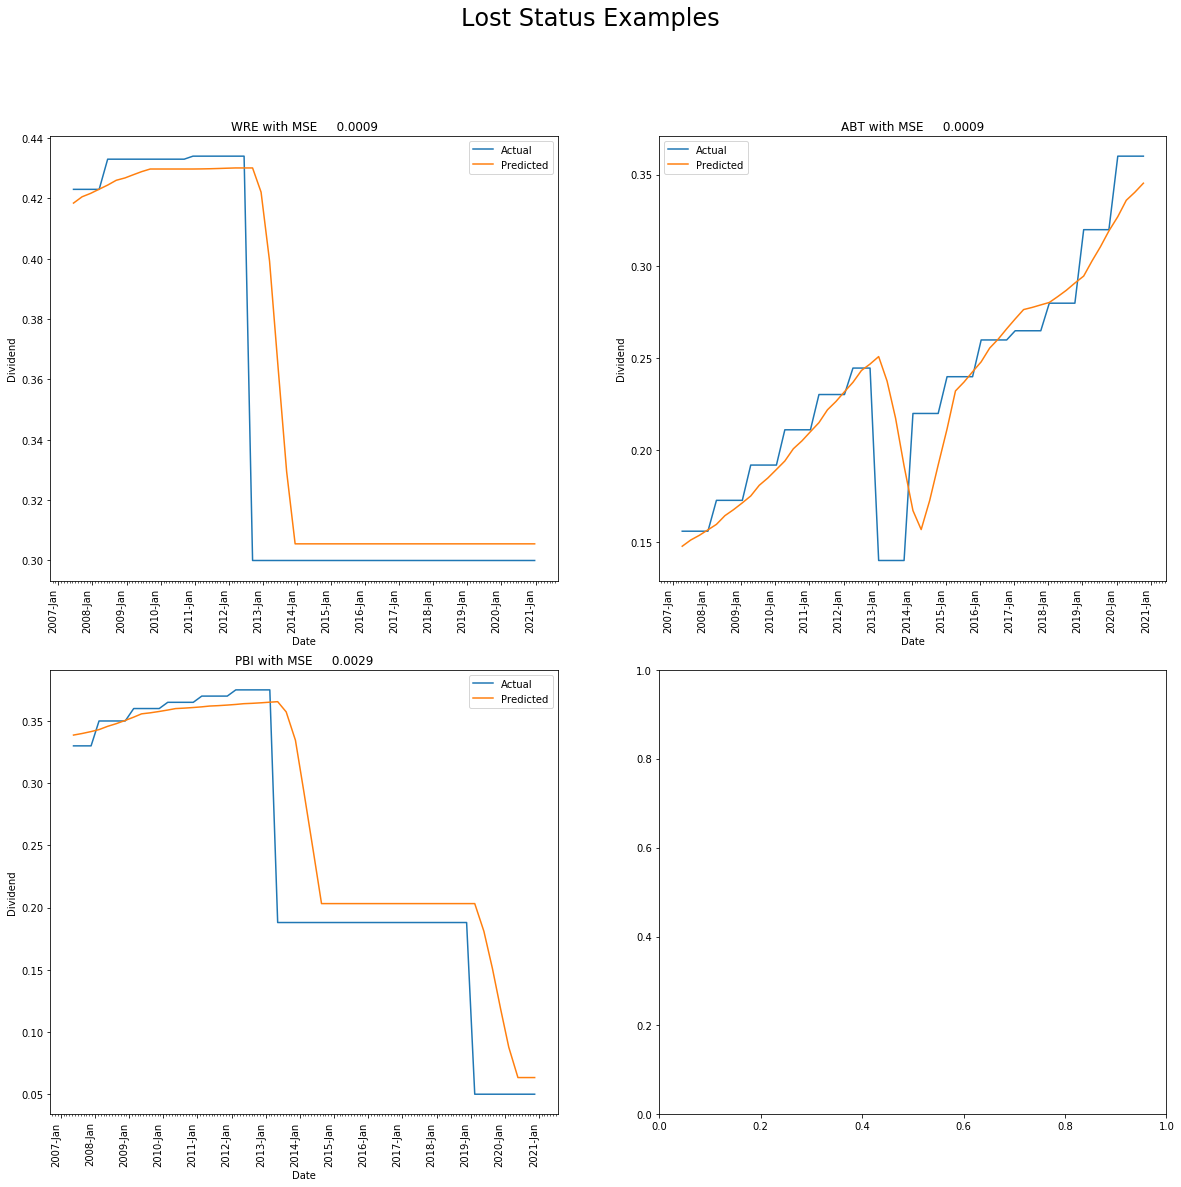

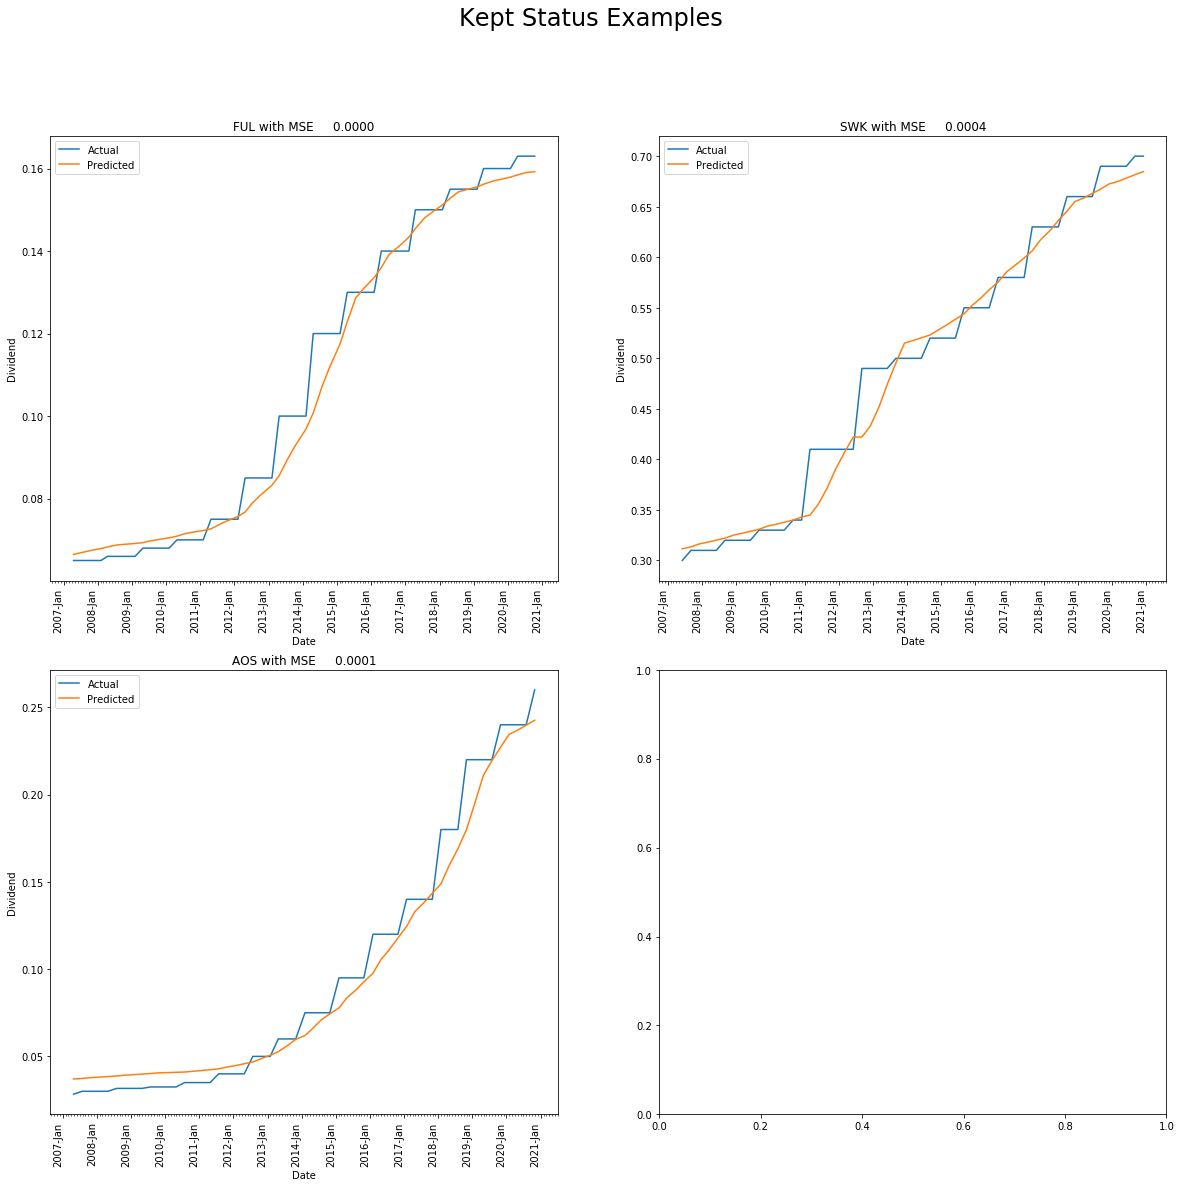

In [18]:
pred_result = {}

lost_ct = 0
kept_ct = 0


lost_fig, lost_axs = plt.subplots(2,2,figsize=(20, 18))        
lost_fig.suptitle("Lost Status Examples", fontsize=24)

kept_fig, kept_axs = plt.subplots(2,2,figsize=(20, 18))        
kept_fig.suptitle("Kept Status Examples", fontsize=24)

for i in stockListFix:
    # if i in shufStockList:
        y_true = scaler[i].inverse_transform(testset[i]["y"].reshape(-1,1))
        y_pred = scaler[i].inverse_transform(regressor.predict(testset[i]["X"]))
        mse = mean_squared_error(y_true, y_pred)
        pred_result[i] = {}
        pred_result[i]["True"] = y_true
        pred_result[i]["Pred"] = y_pred

        if i in lost_figs and lost_ct <= 3:
            indx = lost_ct
            axs = lost_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
            axs[indx].plot(pd.DatetimeIndex(testDates[i]), y_true)
            axs[indx].plot(pd.DatetimeIndex(testDates[i]),y_pred)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Predicted"])
            axs[indx].set_title("{} with MSE {:10.4f}".format(i,mse))
            lost_ct += 1

        if i in kept_figs and kept_ct <= 3:
            indx = kept_ct
            axs = kept_axs.flat
            axs[indx].xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1)))
            axs[indx].xaxis.set_minor_locator(mdates.MonthLocator())
            axs[indx].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))    
            axs[indx].plot(pd.DatetimeIndex(testDates[i]), y_true)
            axs[indx].plot(pd.DatetimeIndex(testDates[i]),y_pred)
            axs[indx].set_ylabel("Dividend")
            axs[indx].set_xlabel("Date")
            for label in axs[indx].get_xticklabels(which='major'):
                label.set(rotation=90, horizontalalignment='right')
            axs[indx].legend(["Actual", "Predicted"])
            axs[indx].set_title("{} with MSE {:10.4f}".format(i,mse))
            kept_ct += 1

plt.show()

In [19]:
scaler["DBD"].inverse_transform(testset["DBD"]["y"].reshape(-1,1))

KeyError: 'DBD'

In [ ]:
testset["BMS"]["y"],df_new["BMS"]["Test"]

In [22]:
time_index = df_new["WRE"]["Test"][overlap:].index
def lagging(df, lag, time_index):
    df_pred = pd.Series(df["Pred"].reshape(-1), index=time_index)
    df_true = pd.Series(df["True"].reshape(-1), index=time_index)
    
    df_pred_lag = df_pred.shift(lag)
    
    print("MSE without Lag", mean_squared_error(np.array(df_true), np.array(df_pred)))
    print("MSE with Lag 5", mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag])))

    fig, axs = plt.subplots(1,1,figsize=(10, 7))
    axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axs.xaxis.set_minor_locator(mdates.MonthLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  
    axs.plot(df_true)
    axs.plot(df_pred)
    axs.set_ylabel("Dividend")
    axs.set_xlabel("Date")
    for label in axs.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')

    axs.legend(["Actual", "Predicted"])
    axs.set_title("Prediction")
    plt.show()

    MSE_lag = mean_squared_error(np.array(df_true[:lag]), np.array(df_pred_lag[:lag]))
    fig, axs = plt.subplots(1,1,figsize=(10, 7))
    axs.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    axs.xaxis.set_minor_locator(mdates.MonthLocator())
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))  
    axs.plot(df_true)
    axs.plot(df_pred_lag)
    axs.set_ylabel("Dividend")
    axs.set_xlabel("Date")
    for label in axs.get_xticklabels(which='major'):
        label.set(rotation=90, horizontalalignment='right')

    axs.legend(["Actual", "Predicted"])
    axs.set_title("{} (Lag Adjusted) with MSE {:10.4f}".format("WRE",MSE_lag))
    plt.savefig("WRE_Prediction_Lag.png", format="png")

    plt.show()
    

MSE without Lag 0.0008547780954724762
MSE with Lag 5 0.0005505110042277619


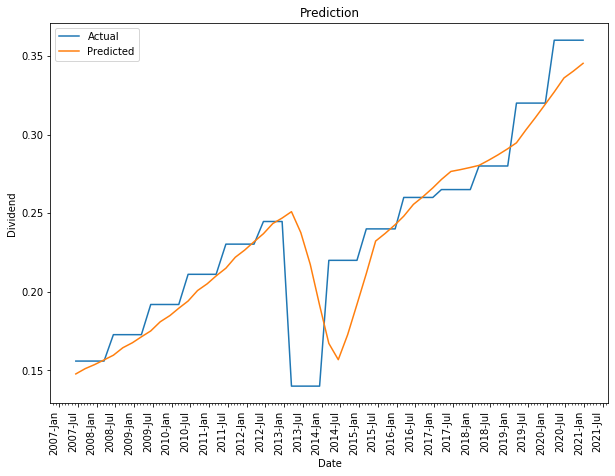

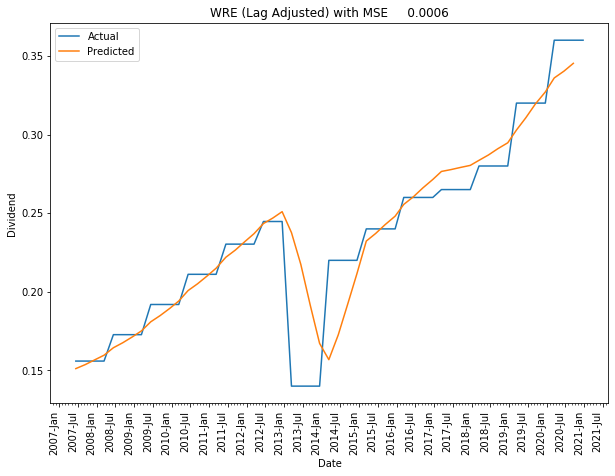

In [25]:
lagging(pred_result["ABT"], -1, time_index)